In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
from thesis.glitch import GlitchModel, GlitchPrior

import thesis.jaxdaw as jd
jdist = jd.distributions

import jax
import jax.numpy as jnp
from jax import random
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

rng = random.PRNGKey(0)

In [2]:
v = Vizier(row_limit=-1)
tables = v.query_constraints("J/ApJ/835/172/table6", KIC="12069424")
df = tables[0].to_pandas()
mask = (df.l == 0) & (df.lnK == 6.0)
df = df.loc[mask]
df

,KIC,n,l,Freq,e_Freq,E_Freq,Amp,e_Amp,E_Amp,Width,e_Width,E_Width,l_lnK,lnK
1,12069424,12,0,1390.80819,0.75733,0.96935,1.03512,0.14780,0.20868,1.37054,0.52924,4.48112,>,6.0
4,12069424,13,0,1495.05303,0.24309,0.22749,0.95483,0.05547,0.11515,1.81378,0.44172,0.75230,>,6.0
7,12069424,14,0,1598.68962,0.07498,0.06914,1.22720,0.05720,0.08730,0.78436,0.12820,0.24575,>,6.0
10,12069424,15,0,1700.95243,0.10148,0.10134,1.63692,0.07382,0.05323,1.41792,0.17727,0.20838,>,6.0
13,12069424,16,0,1802.35128,0.08378,0.07515,2.16288,0.06928,0.06374,1.29415,0.16222,0.09853,>,6.0
16,12069424,17,0,1904.52077,0.05845,0.05825,2.58001,0.08843,0.05659,1.04231,0.07605,0.12258,>,6.0
19,12069424,18,0,2007.53798,0.04187,0.04726,3.28737,0.09241,0.07175,1.00270,0.06517,0.07839,>,6.0
23,12069424,19,0,2110.94955,0.03737,0.04407,3.85151,0.05937,0.11127,0.81538,0.05443,0.05549,>,6.0
27,12069424,20,0,2214.22506,0.05468,0.05287,4.03359,0.07931,0.11501,1.22038,0.07071,0.07990,>,6.0
31,12069424,21,0,2317.28211,0.05534,0.05855,3.61470,0.04919,0.10279,1.24285,0.09264,0.05525,>,6.0


In [3]:
n, nu, nu_low, nu_high = df.n.to_numpy(), df.Freq.to_numpy(), df.e_Freq.to_numpy(), df.E_Freq.to_numpy()
nu_err = np.stack([nu_low, nu_high]).max(axis=0)

# Lund et al. (2017)
delta_nu = jdist.Normal(103.28, 0.05)
epsilon = jdist.Normal(1.45, 0.05)
prior = GlitchPrior(delta_nu, epsilon)
model = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

print(f"{delta_nu.mean:.2f} ± {delta_nu.variance**0.5:.2f}")
print(f"{epsilon.mean:.2f} ± {epsilon.variance**0.5:.2f}")

103.28 ± 0.05
1.45 ± 0.05


In [4]:
rng, key = random.split(rng)
prior_samples = prior.sample(key, shape=(1000,))

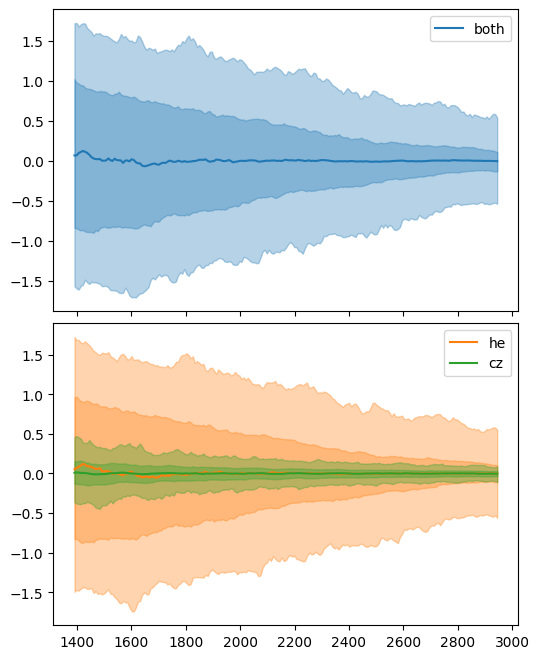

In [5]:
intervals = [(.16, .84), (.025, .975)]

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, gridspec_kw={"hspace": 0.04})
ax0 = model.plot_glitch(prior_samples, intervals=intervals, ax=axes[0])
ax0.legend()

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(prior_samples, kind=kind, intervals=intervals, color=f"C{i+1}", ax=ax1)
ax1.legend();

(-5.0, 5.0)

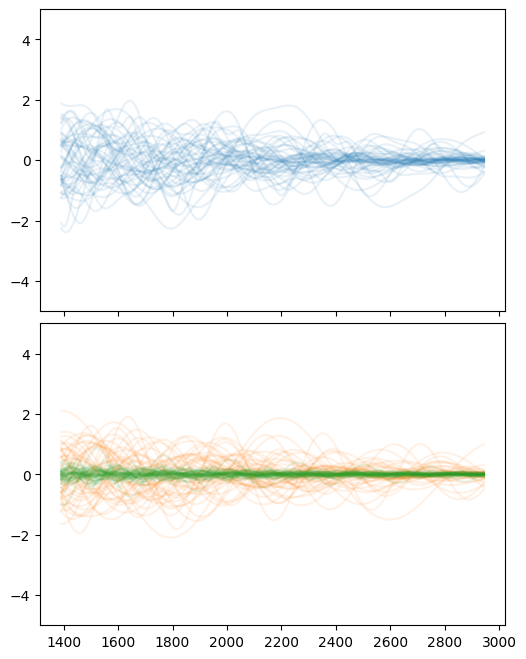

In [6]:
draws = 50
alpha = 0.1

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, sharey=True, gridspec_kw={"hspace": 0.04})
ax0 = model.plot_glitch(prior_samples, draws=draws, alpha=alpha, ax=axes[0])

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(prior_samples, kind=kind, draws=draws, alpha=alpha, color=f"C{i+1}", ax=ax1)

ax1.set_ylim(-5, 5)

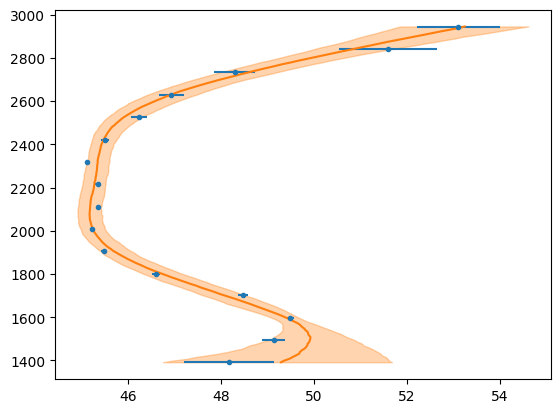

In [7]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, prior_samples, intervals=[(.16, .84)])

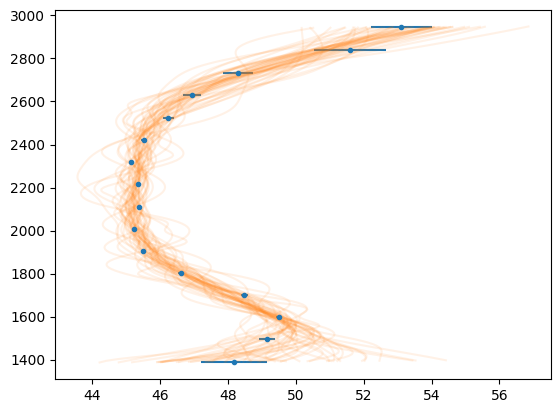

In [8]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, prior_samples, draws=50, alpha=0.1)

In [9]:
rstate = np.random.default_rng(0)
sampler = jd.NestedSampler(model, nlive=500, sample="rwalk", walks=50, rstate=rstate)

In [10]:
%%time
results = sampler.run_nested()

4841it [00:40, 120.86it/s, +500 | bound: 42 | nc: 1 | ncall: 173156 | eff(%):  3.093 | loglstar:   -inf < -10.342 <    inf | logz: -19.396 +/-  0.138 | dlogz:  0.001 >  0.509]

CPU times: user 41.8 s, sys: 7.6 s, total: 49.4 s
Wall time: 40.1 s


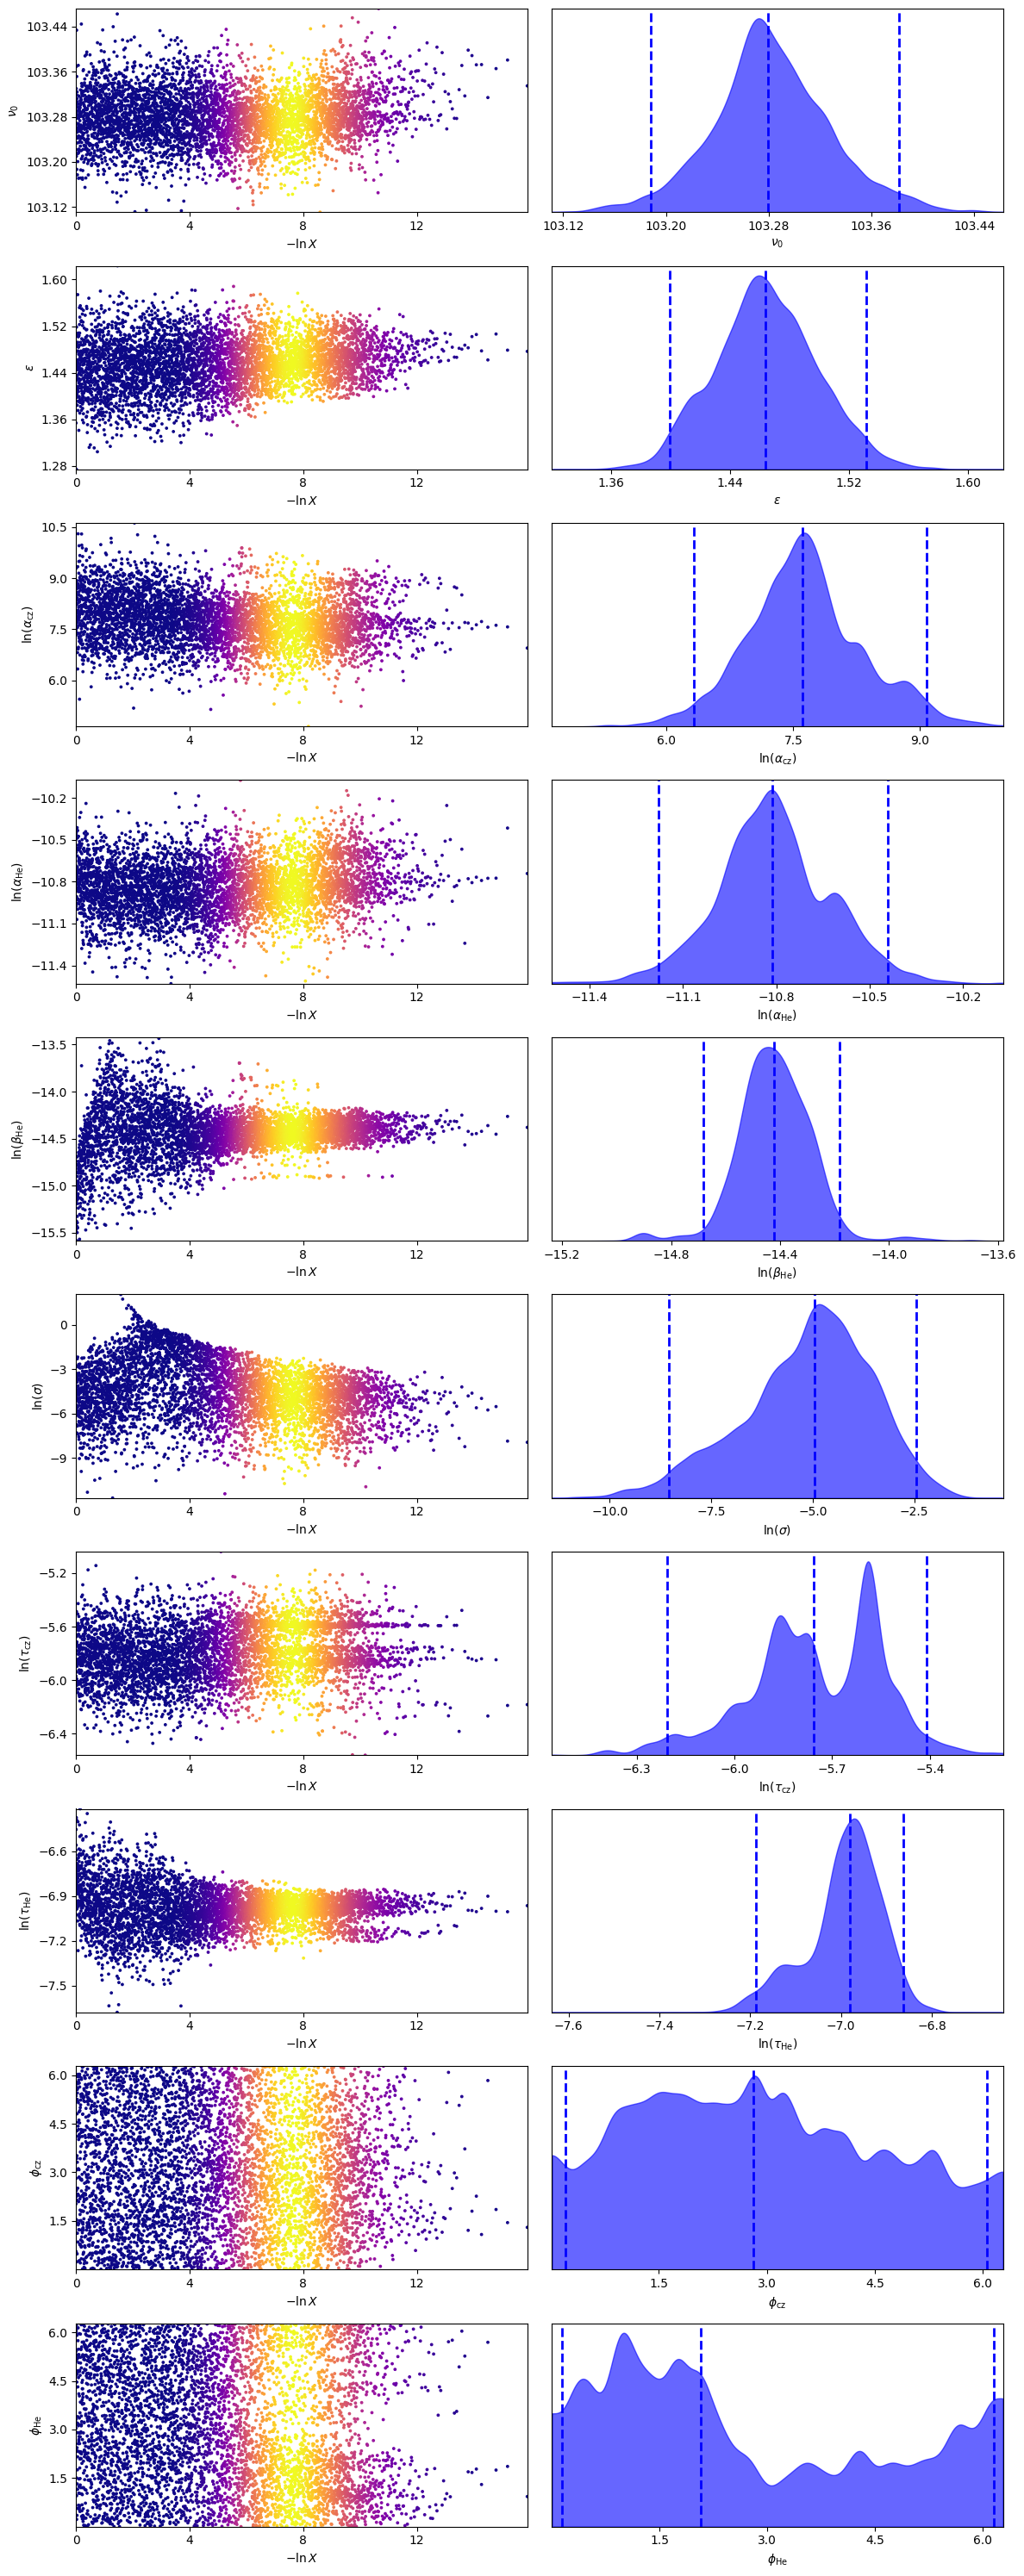

In [11]:
fig, axes = jd.traceplot(results, labels=model.symbols)
fig.tight_layout()

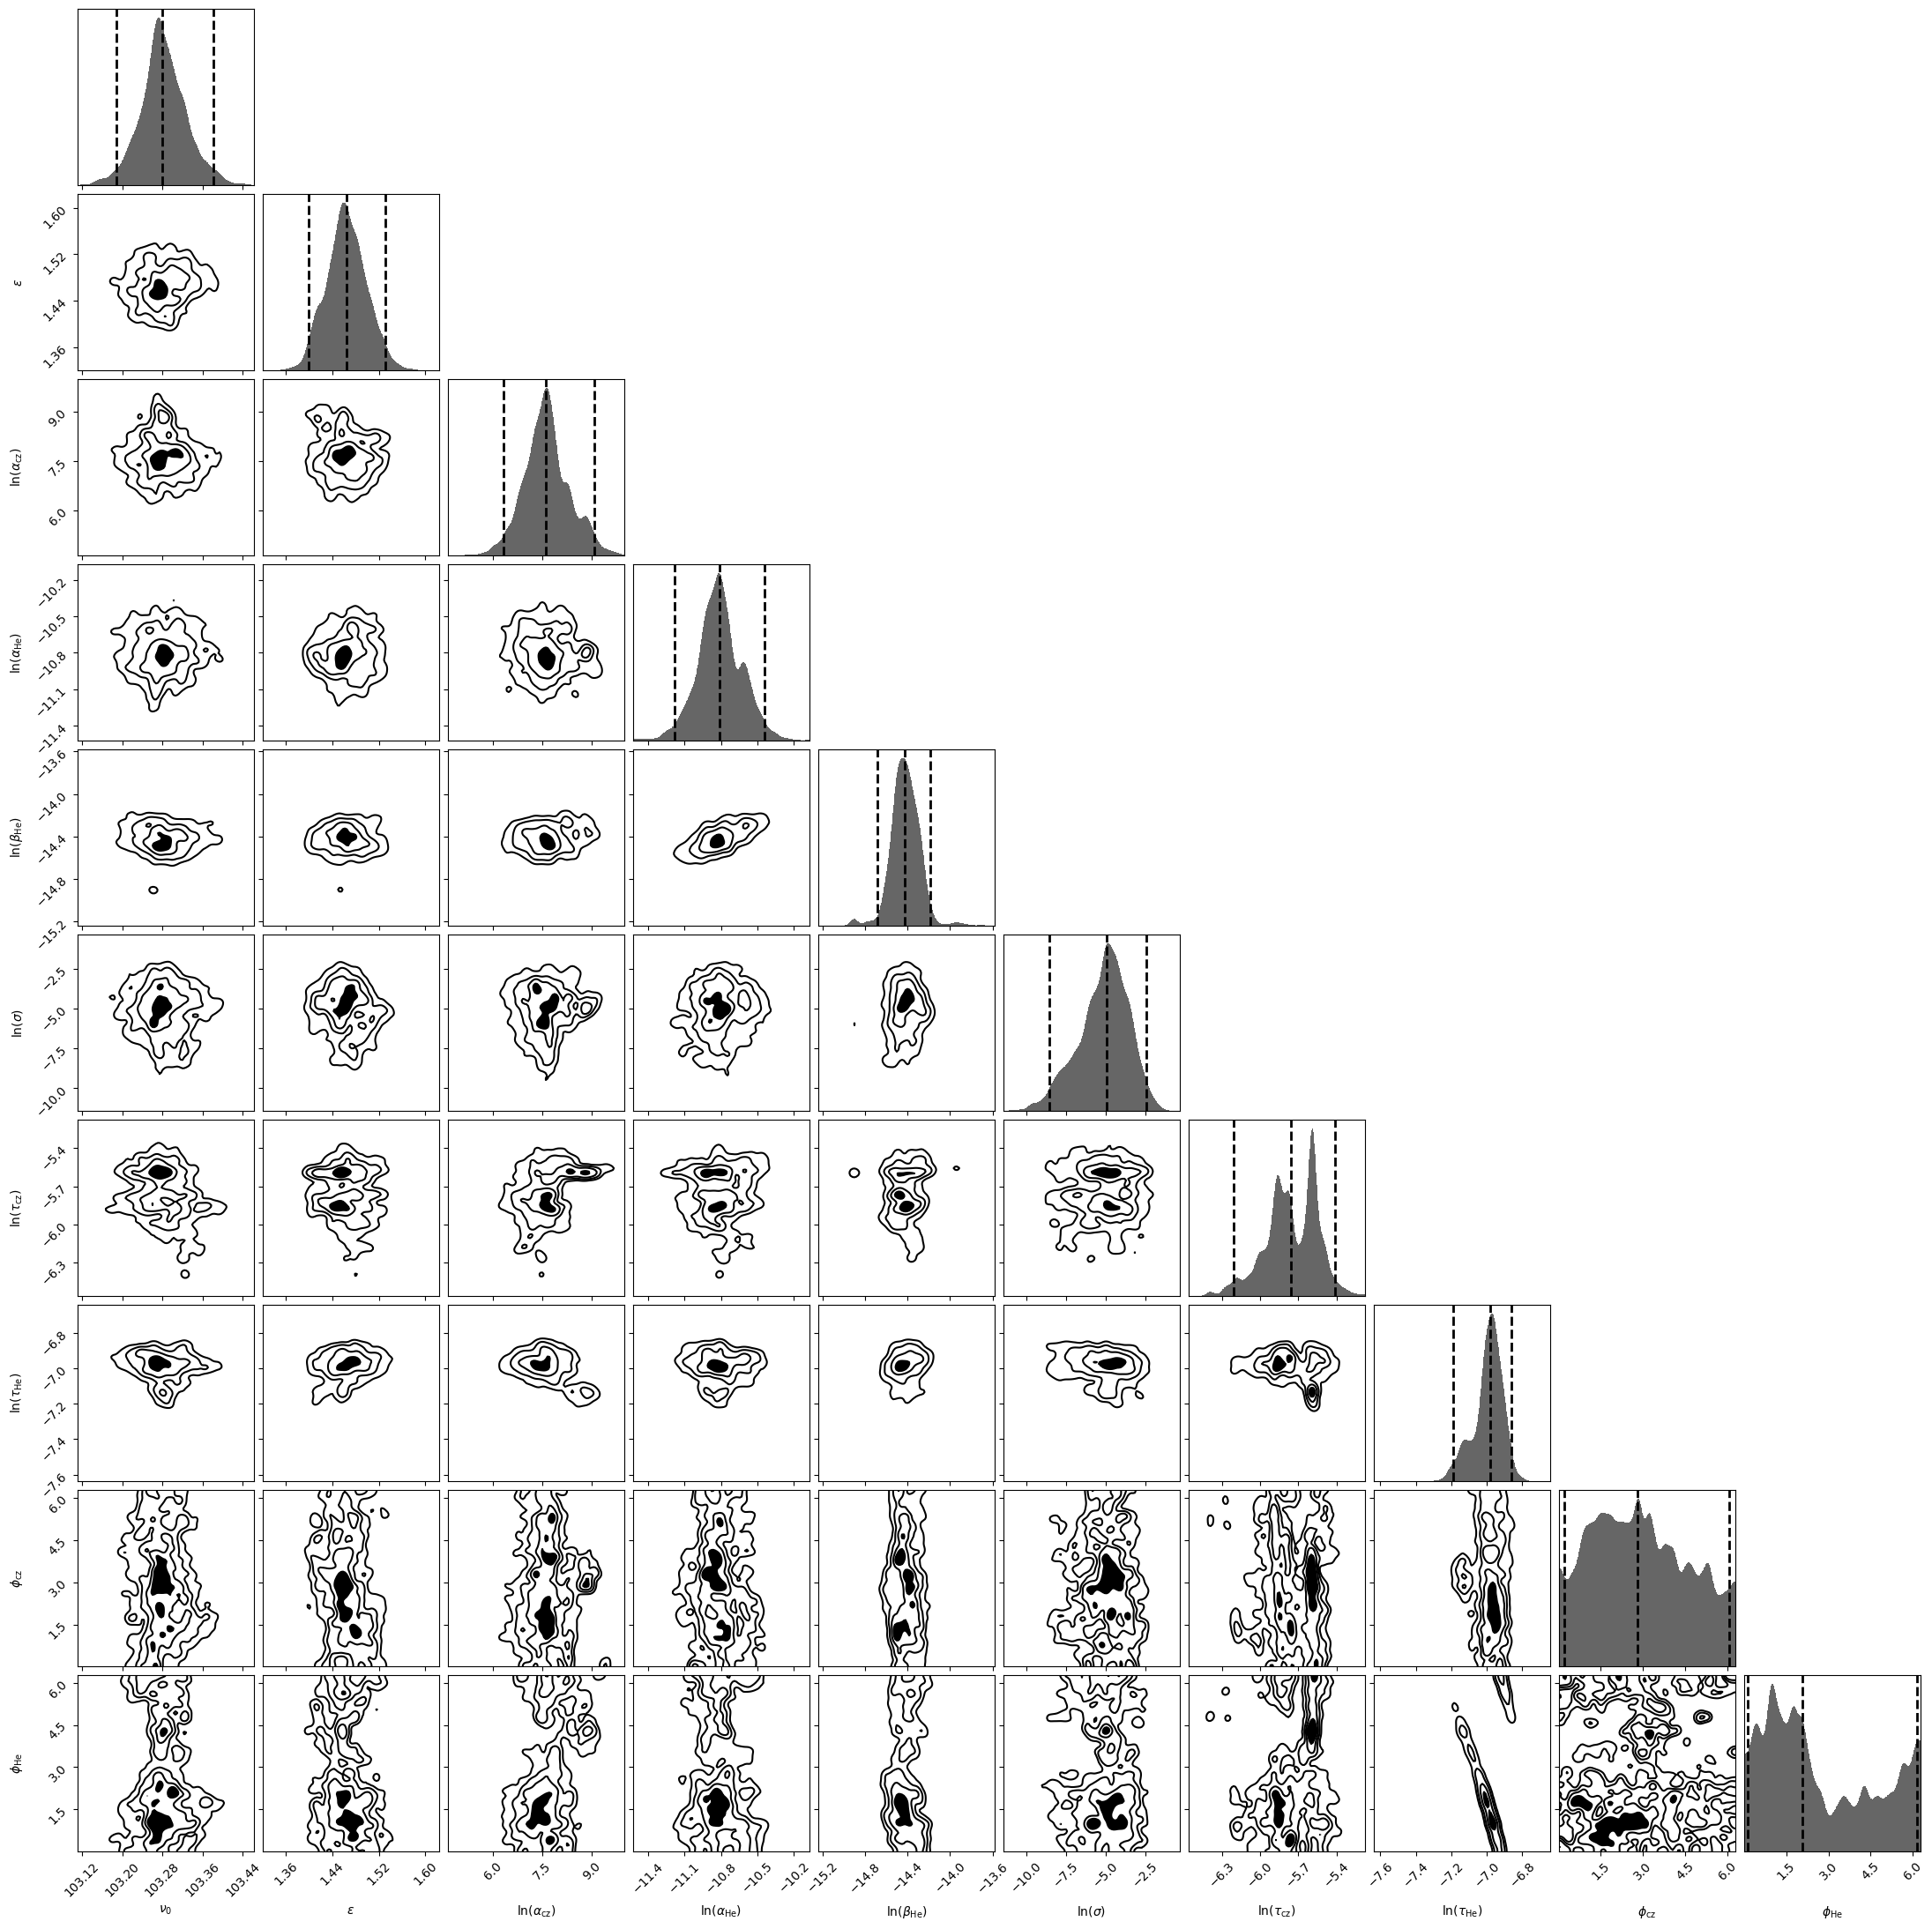

In [12]:
fig, ax = jd.cornerplot(results, labels=model.symbols)

In [13]:
filepath = f"data/gp-glitch-results-16cyga.h5"
jd.save_results(results, filepath)

In [14]:
shape = (1000,)
rng, key = random.split(key)

samples = jd.resample(key, results, shape=shape)

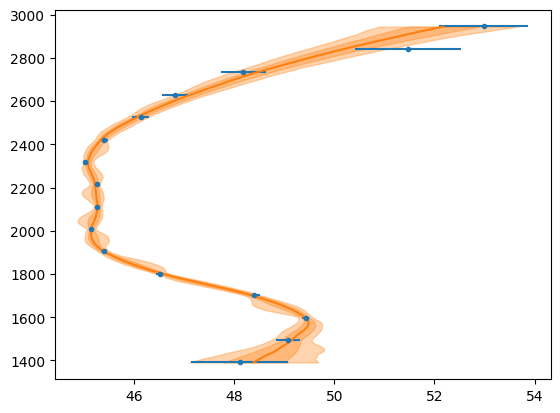

In [15]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, samples, intervals=[(.16, .84), (.025, .975)])

In [16]:
nu_ref = 2188.5

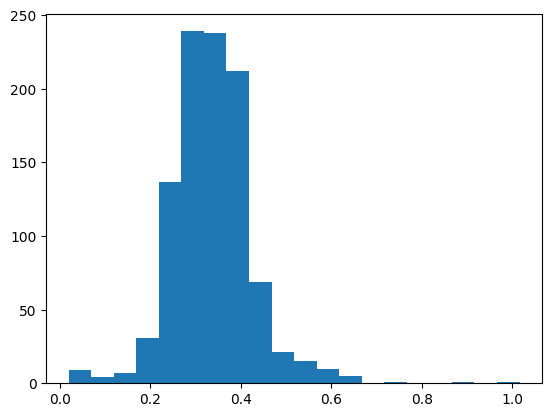

In [17]:
fig, ax = plt.subplots()
ax.hist(model.helium_amp(samples, nu_ref), bins=20);

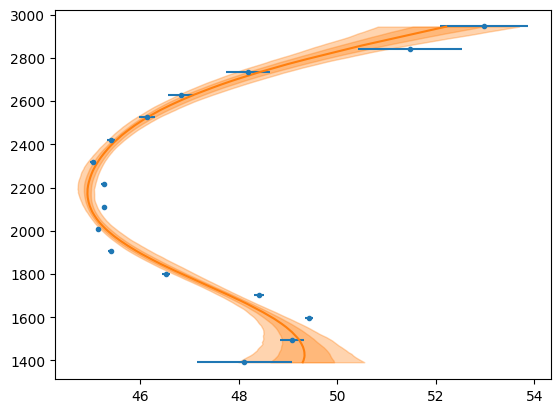

In [18]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, samples, kind="gp", intervals=[(.16, .84), (.025, .975)])

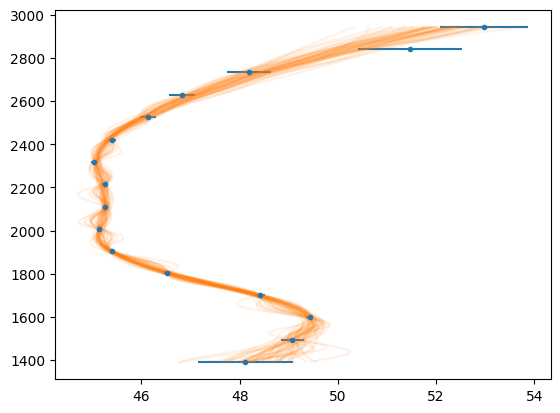

In [19]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, samples, draws=50, alpha=0.1)

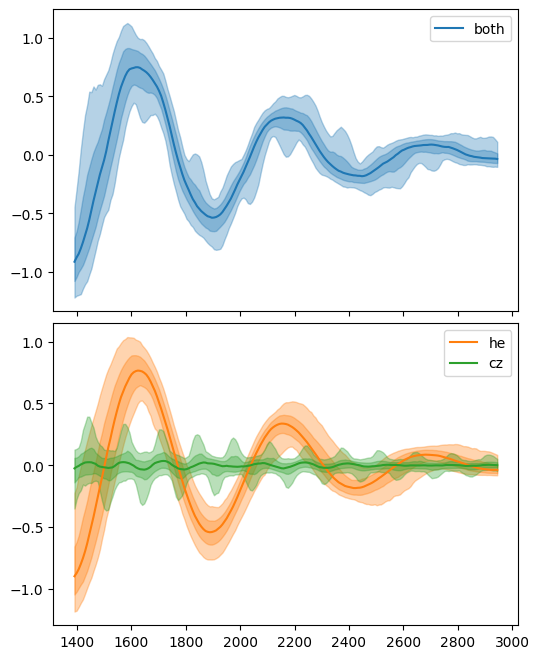

In [20]:
intervals = [(.16, .84), (.025, .975)]

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, gridspec_kw={"hspace": 0.04})
ax0 = model.plot_glitch(samples, intervals=intervals, ax=axes[0])

ax0.legend()

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(samples, kind=kind, intervals=intervals, color=f"C{i+1}", ax=ax1)
ax1.legend();

In [21]:
# be careful, this is slow with large numbers of samples
nu_mean, _ = jax.vmap(model.predict, in_axes=(0, None))(samples, n)
dnu = jax.vmap(model.glitch, in_axes=(0, 0))(samples, nu_mean)

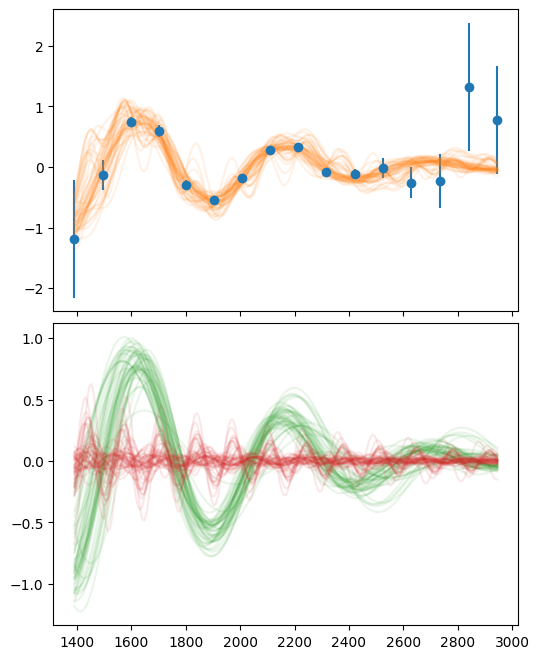

In [22]:
draws = 50
alpha = 0.1

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, gridspec_kw={"hspace": 0.04})

res = (model.nu - nu_mean)
ax0 = axes[0]
ax0.errorbar(model.nu, res.mean(axis=0) + dnu.mean(axis=0), yerr=model.nu_err, fmt="o")

ax0 = model.plot_glitch(samples, draws=draws, alpha=alpha, ax=axes[0])

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(samples, kind=kind, draws=draws, alpha=alpha, color=f"C{i+2}", ax=ax1)